In [11]:
from numpy.random import default_rng
import pandas as pd
import numpy as np

potentialCusts = 200
purchaseProb = 0.2

rng = default_rng(seed = 111) 
numSims = 100

# create data frame to store simulated demand
newsDF = pd.DataFrame({"simNum": range(1, numSims+1),  # sequence of 1 to 100
                   "demand": rng.binomial(n = potentialCusts, 
                                          p = purchaseProb,
                                          size = numSims)})

# view first few 5 rows of newsDF
newsDF.iloc[:5,:]

,simNum,demand
0,1,42
1,2,47
2,3,43
3,4,41
4,5,38


In [1]:
from jax import grad, vmap
import jax.numpy as jnp

## write utility function in Python
def utilityFunction(x):
    # x represents number of consumed pizza slices
    utility = 4*x - x**2   # x**2 is the square of x
    return utility

## check it works, e.g. for u(1) should = 3
print(utilityFunction(1))

3


In [3]:
simNum = 1
xValue = 1
df = pd.DataFrame({"simNum": [simNum], "x": [xValue],
                   "utility": utilityFunction(xValue)})
df

,simNum,x,utility
0,1,1,3


In [4]:
## define gradient of u(x) (i.e. the slope)
utilityFunction_dx = grad(utilityFunction)

## show gradients (slope) at various x-values
x = 1.

## add gradient column to dataframe
gradient = utilityFunction_dx(x)
df["gradient"] = gradient.item()  ##ARGH: convert device array to scalar
df


,simNum,x,utility,gradient
0,1,1,3,2.0


In [5]:
## increment simulation number
simNum = simNum + 1

## step size
stepSize = 0.2

## decide which x to try next
if gradient >= 0:
  xValue = xValue + stepSize
else:
  xValue = xValue - stepSize

## get variable values for new row
utility = utilityFunction(xValue)
gradient = utilityFunction_dx(xValue).item()
newRow = pd.Series({"simNum": simNum,
                    "x": xValue,
                    "utility": utility,
                    "gradient": gradient})

## Append single new row to dataframe
df = pd.concat([df, newRow.to_frame().T], ignore_index = True)
df

,simNum,x,utility,gradient
0,1.0,1.0,3.00,2.0
1,2.0,1.2,3.36,1.6


In [6]:
maxSteps = 10 ## set to avoid looping forever
for _ in range(0,maxSteps):
    ## increment simulation number
    simNum = simNum + 1

    ## decide which x to try next
    if gradient >= 0:
        xValue = xValue + stepSize
    else:
        xValue = xValue - stepSize

    ## get variable values for new row
    utility = utilityFunction(xValue)
    gradient = utilityFunction_dx(xValue).item()
    newRow = pd.Series({"simNum": simNum,
                        "x": xValue,
                        "utility": utility,
                        "gradient": gradient})

    ## Append single new row to dataframe
    df = pd.concat([df, newRow.to_frame().T], ignore_index = True)

    ## break out of for loop is gradient val is sufficiently small
    if abs(gradient) < 0.1:
        break
      
df

,simNum,x,utility,gradient
0,1.0,1.0,3.00,2.0
1,2.0,1.2,3.36,1.6
2,3.0,1.4,3.64,1.2
3,4.0,1.6,3.84,0.8
4,5.0,1.8,3.96,0.4
5,6.0,2.0,4.00,0.0


In [7]:
from functools import partial

## write loss function in Python
def lossFunction(d,q):
    loss = abs(d-q)  ## using jax version of abs 
    return loss

## convert from pandas series type to jax array
## all input arrays should be jax arrays for optimizing
demand = jnp.array(newsDF.demand)
## create partial loss function where samples of d are known
lossGivenQ = partial(lossFunction,d = demand)

## showcasing two ways of computing exp loss, 
## we will learn to prefer the 2nd form
newsDF["lossForOQ40"] = lossFunction(d = newsDF.demand, q = 40)
newsDF["lossForOQ42"] = lossGivenQ(q = 42)

newsDF ## show results


,simNum,demand,lossForOQ40,lossForOQ42
0,1,42,2,0
1,2,47,7,5
2,3,43,3,1
3,4,41,1,1
4,5,38,2,4
...,...,...,...,...
95,96,47,7,5
96,97,43,3,1
97,98,47,7,5
98,99,31,9,11


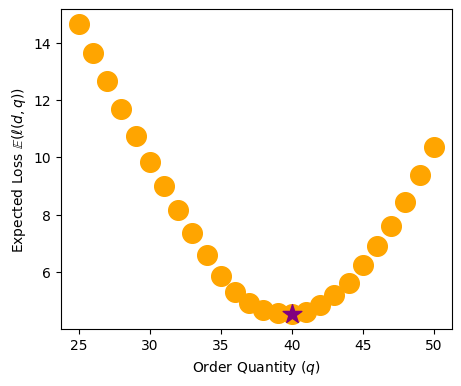

In [8]:
from numpy import linspace
import matplotlib.pyplot as plt
import pandas as pd

# initialize canvas and axes to plot on
## plot the results using matplotlib object-oriented interface
fig, ax = plt.subplots(figsize = [4.5,3.75], layout = "constrained");
ax.set_xlabel("Order Quantity" + r" ($q$)");
ax.set_ylabel("Expected Loss" + r" $\mathbb{E} \left(\ell(d,q)\right)$");

bestQ = 0
minLoss = float('inf')

for orderQty in range(25,50+1):
    expLoss = jnp.mean(lossGivenQ(q=orderQty))
    ax.scatter(orderQty,expLoss, s= 200, marker = "o", c = "orange");
    ## record to find minimum
    if expLoss < minLoss:
        minLoss = expLoss
        bestQ = orderQty

## place a purple star over the minimum
ax.scatter(bestQ,minLoss, s= 200, marker = "*", c = "purple");
plt.show();

In [9]:
# simulation parameters
stepSize = 1
maxSteps = 1000

# starting point
currentQ = 50. ## make float to avoid error

# expLossFunction
def expLossFun(q):
    expLoss = jnp.mean(lossGivenQ(q=q))
    return expLoss

# gradient of exp loss function
newsvGradient = grad(expLossFun)

# take steps towards optimum
for _ in range(0,maxSteps):
    gradientValue = newsvGradient(currentQ).item() #return just value
    ## break out of for loop is gradient val is sufficiently small
    if abs(gradientValue) < 0.1:
        break
    ## pick whether to increase or decrease order quantity
    ## NOTE: for minimizing steps are in direction of negative gradient
    if newsvGradient(currentQ) >= 0:
        ## if gradient is positive reduce q
        currentQ = currentQ - stepSize
    else:
        ## if gradient is negative increase q
        currentQ = currentQ + stepSize

# print optimum
print("The optimal order quantity is ", currentQ, " with expected loss of ", expLossFun(currentQ),".")

The optimal order quantity is  41.0  with expected loss of  4.5899997 .


In [12]:
from numpy.random import default_rng
import numpy as np
import xarray as xr

rng = default_rng(seed = 111)  ## set random seed 
demand = rng.binomial(n=200,p=0.2,size=100)   ## get demand values

## make data array
xr.DataArray(data = demand)

<xarray.DataArray (dim_0: 100)>
array([42, 47, 43, 41, 38, 40, 41, 45, 29, 29, 49, 44, 41, 46, 40, 39, 37,
       41, 37, 37, 38, 28, 28, 39, 48, 38, 47, 41, 43, 37, 40, 41, 35, 44,
       41, 35, 35, 39, 35, 47, 45, 35, 30, 48, 44, 38, 35, 40, 44, 41, 38,
       47, 42, 35, 36, 36, 44, 37, 42, 41, 40, 36, 36, 43, 43, 48, 27, 44,
       38, 37, 32, 48, 49, 29, 37, 44, 46, 42, 33, 36, 49, 33, 46, 35, 36,
       34, 45, 36, 41, 44, 35, 36, 38, 31, 50, 47, 43, 47, 31, 37])
Dimensions without coordinates: dim_0

In [13]:
potentialCusts = 200
purchaseProb = 0.2

rng = default_rng(seed = 111) 
numSims = 100

# create data frame to store simulated demand
newsDF = pd.DataFrame({"simNum": range(1, numSims+1),  # sequence of 1 to 100
                   "demand": rng.binomial(n = potentialCusts, 
                                          p = purchaseProb,
                                          size = numSims)})

## google SEARCH PHRASE: get element-wise minimum of two columns in pandas dataframe
newsDF["profit_q42"] = 3 * np.minimum(newsDF.demand,42) - 1 * 42
newsDF["lostSales_q42"] = np.maximum(0,newsDF.demand - 42)

# view first few 5 rows of newsDF
newsDF.iloc[:5,:]

,simNum,demand,profit_q42,lostSales_q42
0,1,42,84,0
1,2,47,84,5
2,3,43,84,1
3,4,41,81,0
4,5,38,72,0


In [14]:
## make data array with labelled dimension name
xr.DataArray(data = demand, dims = "draw")

<xarray.DataArray (draw: 100)>
array([42, 47, 43, 41, 38, 40, 41, 45, 29, 29, 49, 44, 41, 46, 40, 39, 37,
       41, 37, 37, 38, 28, 28, 39, 48, 38, 47, 41, 43, 37, 40, 41, 35, 44,
       41, 35, 35, 39, 35, 47, 45, 35, 30, 48, 44, 38, 35, 40, 44, 41, 38,
       47, 42, 35, 36, 36, 44, 37, 42, 41, 40, 36, 36, 43, 43, 48, 27, 44,
       38, 37, 32, 48, 49, 29, 37, 44, 46, 42, 33, 36, 49, 33, 46, 35, 36,
       34, 45, 36, 41, 44, 35, 36, 38, 31, 50, 47, 43, 47, 31, 37])
Dimensions without coordinates: draw

In [15]:
## explicit labeling of coordinates - must use name now to create dataset later
demandDA = xr.DataArray(data = demand, coords = {"draw": np.arange(100)+1}, name = "demand")
demandDA

<xarray.DataArray 'demand' (draw: 100)>
array([42, 47, 43, 41, 38, 40, 41, 45, 29, 29, 49, 44, 41, 46, 40, 39, 37,
       41, 37, 37, 38, 28, 28, 39, 48, 38, 47, 41, 43, 37, 40, 41, 35, 44,
       41, 35, 35, 39, 35, 47, 45, 35, 30, 48, 44, 38, 35, 40, 44, 41, 38,
       47, 42, 35, 36, 36, 44, 37, 42, 41, 40, 36, 36, 43, 43, 48, 27, 44,
       38, 37, 32, 48, 49, 29, 37, 44, 46, 42, 33, 36, 49, 33, 46, 35, 36,
       34, 45, 36, 41, 44, 35, 36, 38, 31, 50, 47, 43, 47, 31, 37])
Coordinates:
  * draw     (draw) int64 1 2 3 4 5 6 7 8 9 10 ... 92 93 94 95 96 97 98 99 100

In [16]:
## creating a DataArray of order quantities - must use name now to create dataset later
orderDA = xr.DataArray(data = np.arange(25,51), 
                       coords = {"orderQtyIndex": np.arange(25,51)},
                       name = "orderQty")
orderDA

<xarray.DataArray 'orderQty' (orderQtyIndex: 26)>
array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49, 50])
Coordinates:
  * orderQtyIndex  (orderQtyIndex) int64 25 26 27 28 29 30 ... 45 46 47 48 49 50

In [17]:
# create dataset by combining data arrays
newsvDS = xr.merge([demandDA,orderDA])
newsvDS

<xarray.Dataset>
Dimensions:        (draw: 100, orderQtyIndex: 26)
Coordinates:
  * draw           (draw) int64 1 2 3 4 5 6 7 8 9 ... 93 94 95 96 97 98 99 100
  * orderQtyIndex  (orderQtyIndex) int64 25 26 27 28 29 30 ... 45 46 47 48 49 50
Data variables:
    demand         (draw) int64 42 47 43 41 38 40 41 45 ... 31 50 47 43 47 31 37
    orderQty       (orderQtyIndex) int64 25 26 27 28 29 30 ... 45 46 47 48 49 50

In [22]:
newsvDS = (  ## open parenthesis to start readable code
    newsvDS
    .assign(soldNewspapers = np.minimum(newsvDS.demand,newsvDS.orderQty))
) ## close parenthesis finishes the "method chaining"

In [23]:
(  ## open parenthesis to start readable code
    newsvDS
    .assign(soldNewspapers = np.minimum(newsvDS.demand,newsvDS.orderQty))
    .assign(revenue = 3 * newsvDS.soldNewspapers)
) ## close parenthesis finishes the "method chaining"

<xarray.Dataset>
Dimensions:         (draw: 100, orderQtyIndex: 26)
Coordinates:
  * draw            (draw) int64 1 2 3 4 5 6 7 8 9 ... 93 94 95 96 97 98 99 100
  * orderQtyIndex   (orderQtyIndex) int64 25 26 27 28 29 30 ... 46 47 48 49 50
Data variables:
    demand          (draw) int64 42 47 43 41 38 40 41 ... 31 50 47 43 47 31 37
    orderQty        (orderQtyIndex) int64 25 26 27 28 29 30 ... 46 47 48 49 50
    soldNewspapers  (draw, orderQtyIndex) int64 25 26 27 28 29 ... 37 37 37 37
    revenue         (draw, orderQtyIndex) int64 75 78 81 84 ... 111 111 111 111

In [24]:
(  ## open parenthesis to start readable code
    newsvDS
    .assign(soldNewspapers = np.minimum(newsvDS.demand,newsvDS.orderQty))
    .assign(revenue = lambda DS: 3 * DS.soldNewspapers)
) ## use lambda function to get current state of dataset in chain

<xarray.Dataset>
Dimensions:         (draw: 100, orderQtyIndex: 26)
Coordinates:
  * draw            (draw) int64 1 2 3 4 5 6 7 8 9 ... 93 94 95 96 97 98 99 100
  * orderQtyIndex   (orderQtyIndex) int64 25 26 27 28 29 30 ... 46 47 48 49 50
Data variables:
    demand          (draw) int64 42 47 43 41 38 40 41 ... 31 50 47 43 47 31 37
    orderQty        (orderQtyIndex) int64 25 26 27 28 29 30 ... 46 47 48 49 50
    soldNewspapers  (draw, orderQtyIndex) int64 25 26 27 28 29 ... 37 37 37 37
    revenue         (draw, orderQtyIndex) int64 75 78 81 84 ... 111 111 111 111

In [25]:
newsvDS = (newsvDS
            .assign(soldNewspapers = np.minimum(newsvDS.demand,newsvDS.orderQty))
            .assign(revenue = lambda DS: 3 * DS.soldNewspapers)
            .assign(expense = 1 * newsvDS.orderQty)
            .assign(profit = lambda DS: DS.revenue - DS.expense)
            .assign(lostSales = np.maximum(0, newsvDS.demand - newsvDS.orderQty))
)

(newsvDS
 .to_dataframe()  #dataframe for printing
 .sample(5, random_state = 111))  ## show five rows of DF

,,demand,orderQty,soldNewspapers,revenue,expense,profit,lostSales
draw,orderQtyIndex,,,,,,,
39,36,35,36,35,105,36,69,0
22,46,28,46,28,84,46,38,0
17,47,37,47,37,111,47,64,0
60,35,41,35,35,105,35,70,6
21,48,38,48,38,114,48,66,0


In [26]:
newsvDS["soldNewspapers"] = np.minimum(newsvDS.demand,newsvDS.orderQty)
newsvDS["expense"] = newsvDS.orderQty
newsvDS["revenue"] = 3 * newsvDS.soldNewspapers
newsvDS["profit"] = newsvDS.revenue - newsvDS.expense
newsvDS["lostSales"] = np.maximum(0, newsvDS.demand - newsvDS.orderQty)
newsvDS

<xarray.Dataset>
Dimensions:         (draw: 100, orderQtyIndex: 26)
Coordinates:
  * draw            (draw) int64 1 2 3 4 5 6 7 8 9 ... 93 94 95 96 97 98 99 100
  * orderQtyIndex   (orderQtyIndex) int64 25 26 27 28 29 30 ... 46 47 48 49 50
Data variables:
    demand          (draw) int64 42 47 43 41 38 40 41 ... 31 50 47 43 47 31 37
    orderQty        (orderQtyIndex) int64 25 26 27 28 29 30 ... 46 47 48 49 50
    soldNewspapers  (draw, orderQtyIndex) int64 25 26 27 28 29 ... 37 37 37 37
    revenue         (draw, orderQtyIndex) int64 75 78 81 84 ... 111 111 111 111
    expense         (orderQtyIndex) int64 25 26 27 28 29 30 ... 46 47 48 49 50
    profit          (draw, orderQtyIndex) int64 50 52 54 56 58 ... 64 63 62 61
    lostSales       (draw, orderQtyIndex) int64 17 16 15 14 13 12 ... 0 0 0 0 0

In [27]:
(newsvDS.where(lambda x: x.lostSales > 0, drop = True)
 .to_dataframe()  #convert to pandas dataframe for printing
 .dropna() # pandas method to remove NaN rows
 .sample(5, random_state = 111))


,,demand,orderQty,soldNewspapers,revenue,expense,profit,lostSales
draw,orderQtyIndex,,,,,,,
30,34,37.0,34.0,34.0,102.0,34.0,68.0,3.0
98,27,47.0,27.0,27.0,81.0,27.0,54.0,20.0
100,26,37.0,26.0,26.0,78.0,26.0,52.0,11.0
83,30,46.0,30.0,30.0,90.0,30.0,60.0,16.0
26,34,38.0,34.0,34.0,102.0,34.0,68.0,4.0


In [28]:
## find average profit by orderQty
## see documentation here: https://docs.xarray.dev/en/stable/generated/xarray.core.groupby.DatasetGroupBy.mean.html
(
    newsvDS
    .get("profit")
    .groupby("orderQtyIndex")
    .mean(...)
).to_dataframe()


,profit
orderQtyIndex,
25,50.00
26,52.00
27,54.00
28,55.97
29,57.88
30,59.70
31,61.49
32,63.22
33,64.92


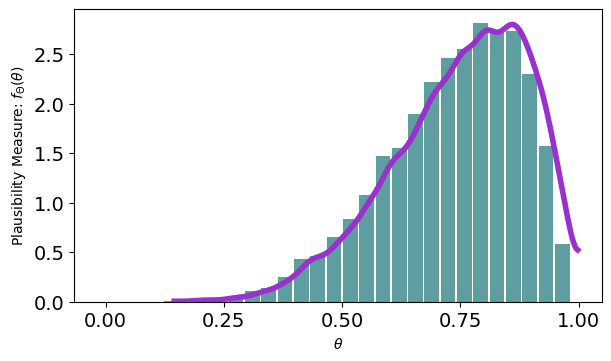

In [29]:
from numpy.random import default_rng
from numpy import linspace
import arviz as az


rng = default_rng(seed = 111)
repSampBeta6_2 = rng.beta(a = 6, b = 2, size = 10000)

fig, ax = plt.subplots(figsize=(6, 3.5),
                        layout='constrained')

# plot histogram
az.plot_dist(repSampBeta6_2, kind = "hist", color = "cadetblue", ax = ax,
             hist_kwargs = {"bins": linspace(0,1,30), "density": True})

# plot density estimate, i.e. estimate of f(x)
az.plot_dist(repSampBeta6_2, ax = ax, color = "darkorchid",
             plot_kwargs = {"zorder": 1, "linewidth": 4})
ax.set_xticks([0,.25,.5,.75,1])

ax.set_ylabel('Plausibility Measure: ' + r'$f_\Theta(\theta)$')
ax.set_xlabel(r'$\theta$')

plt.show()

In [30]:
import random
import pandas as pd
import numpy as np

def simulate_birthday_paradox(num_people):
    # simulate birthday paradox
    num_trials = 1000
    birthdays = np.random.randint(1, 366, size=(num_trials, num_people))
    num_matches = np.sum([len(set(birthday)) != num_people for birthday in birthdays])
    probability = num_matches / num_trials
    return probability



In [34]:
probability = simulate_birthday_paradox(num_people=23)
df = pd.DataFrame({'Number of people': [23], 'Probability': [probability]})


In [13]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set random seed for reproducibility
np.random.seed(42)

# Generate the MA(3) process
n = 2000
theta1 = 0.6
theta2 = 0.4
theta3 = 0.2
errors = np.random.normal(0, 1, n)
series = np.zeros(n)

for t in range(3, n):
    series[t] = errors[t] + theta1 * errors[t - 1] + theta2 * errors[t - 2] + theta3 * errors[t - 3]

# Convert the series to a pandas DataFrame
series_df = pd.DataFrame(series, columns=["Value"])


In [18]:
# Fit the AR model and choose the optimal r
min_aic = float("inf")
optimal_r = None
ar_model = None

for r in range(1, 20):
    model = ARIMA(series_df, order=(r, 0, 0)).fit()
    aic = model.aic
    
    if aic < min_aic:
        min_aic = aic
        optimal_r = r
        ar_model = model

print(f"Optimal AR order: {optimal_r}")


Optimal AR order: 9


In [22]:
# Fit the MA(1) model
ma_model = ARIMA(series_df, order=(0, 0, 3)).fit()

# Forecast using the AR and MA models
ar_forecast = ar_model.get_prediction(start=1, end=n - 1).predicted_mean
ma_forecast = ma_model.get_prediction(start=1, end=n - 1).predicted_mean

# Calculate the mean squared error
ar_mse = mean_squared_error(series_df["Value"][1:], ar_forecast)
ma_mse = mean_squared_error(series_df["Value"][1:], ma_forecast)

print(f"AR model MSE: {ar_mse:.4f}")
print(f"MA model MSE: {ma_mse:.4f}")


AR model MSE: 0.9729
MA model MSE: 0.9755


In [21]:

# Forecast using the AR and MA models
forecast_steps = 10
ar_forecast = ar_model.get_forecast(steps=forecast_steps).predicted_mean
ma_forecast = ma_model.get_forecast(steps=forecast_steps).predicted_mean

# Generate new MA(3) data for comparison
errors_new = np.random.normal(0, 1, n + forecast_steps)
series_new = np.zeros(n + forecast_steps)

for t in range(3, n + forecast_steps):
    series_new[t] = errors_new[t] + theta1 * errors_new[t - 1] + theta2 * errors_new[t - 2] + theta3 * errors_new[t - 3]

# Calculate the mean squared error
ar_mse = mean_squared_error(series_new[-forecast_steps:], ar_forecast)
ma_mse = mean_squared_error(series_new[-forecast_steps:], ma_forecast)

print(f"AR model MSE: {ar_mse:.4f}")
print(f"MA model MSE: {ma_mse:.4f}")

AR model MSE: 6.5168
MA model MSE: 6.2603
